Block of code below is used to toggle the data_table display of dataframes in google colab

# Data Extraction

In [ ]:
# %load_ext google.colab.data_table
# %unload_ext google.colab.data_table

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from datetime import datetime, timedelta

We load data from Google Drive, insert your own path to file here.

In [61]:
lifelog_raw = pd.read_csv('/content/drive/MyDrive/nantes/tspm/Lifelog dataset - Sacha Chua.csv')
# lifelog #display raw lifelog df

Data cleaning step

In [62]:
# we filter useless columns
lifelog = lifelog_raw.copy()
lifelog.drop('Source name', inplace=True, axis=1) # full NaN column
lifelog.drop('Source', inplace=True, axis=1) # full NaN column
lifelog.drop('Data', inplace=True, axis=1) # mostly NaN, useless information when details are provided
lifelog.drop('Beginning of year', inplace=True, axis=1) # all values are 2019-01-01
lifelog.drop('Record category type', inplace=True, axis=1) # all values are "activity"
lifelog.drop('Day', inplace=True, axis=1) # all values are already in "Timestamp" column
lifelog.drop('Beginning of week', inplace=True, axis=1) # all values are already in "Timestamp" column
lifelog.drop('Beginning of month', inplace=True, axis=1) # all values are already in "Timestamp" column
lifelog.drop('Duration', inplace=True, axis=1) # Duration can be computed from Timestamp start and end (and we do it next)

#then we convert some values
# remove category from childcare as it is irrelevant
lifelog['Record category'] = lifelog.apply(lambda row: 'Childcare' if (row['Record category'] == 'A- - Childcare') else row['Record category'], axis=1)

# convert timestamps 
lifelog['Timestamp'] = lifelog.apply(lambda row: datetime.strptime(row['Timestamp'], '%B %d, %Y %H:%M'), axis=1)
lifelog['End timestamp'] = lifelog.apply(lambda row: datetime.strptime(row['End timestamp'], '%B %d, %Y %H:%M'), axis=1)

lifelog['Duration'] = (lifelog['End timestamp'] - lifelog['Timestamp'])
lifelog['Duration'] = lifelog.apply(lambda row: row['Duration'].seconds, axis=1)

lifelog

,Timestamp,End timestamp,Record category,Record category ID,Duration
0,2019-01-01 02:00:00,2019-01-01 09:11:00,Sleep,30,25860
1,2019-01-01 09:11:00,2019-01-01 11:19:00,Childcare,1764,7680
2,2019-01-01 11:19:00,2019-01-01 11:29:00,Personal - Routines,20,600
3,2019-01-01 11:29:00,2019-01-01 16:20:00,Childcare,1764,17460
4,2019-01-01 16:20:00,2019-01-01 16:30:00,Personal - Routines,20,600
...,...,...,...,...,...
4307,2019-12-30 21:13:00,2019-12-30 21:13:00,Discretionary - Productive - Coding,395,0
4308,2019-12-30 21:13:00,2019-12-30 23:12:00,Discretionary - Productive - Sewing,416,7140
4309,2019-12-30 23:12:00,2019-12-30 23:26:00,Discretionary - Productive - Writing,14,840
4310,2019-12-30 23:26:00,2019-12-30 23:49:00,Personal - Routines,20,1380


Below we can see the mapping of category ID to category name. This could be useful latter.

In [129]:
# we map the classes to their class Id ("Record category ID")

categories = pd.DataFrame({'Category':lifelog['Record category'].unique(), 'Id':lifelog['Record category ID'].unique()})
categories = categories.sort_values('Id', ignore_index=True)
categories #display categories df

,Category,Id
0,Discretionary - Family,3
1,Unpaid work - Cook,7
2,Unpaid work - Tidy up,13
3,Discretionary - Productive - Writing,14
4,Discretionary - Social,17
5,Personal - Routines,20
6,Discretionary - Play - Read - Fiction,29
7,Sleep,30
8,Unpaid work - Subway,32
9,Personal - Walk - Other,38


# Data analysis

To get a sense of the data category proportions, we merge core categories together

In [64]:
activities_time = lifelog.copy()
activities_time['category_group'] = activities_time.apply(lambda row: row['Record category'].split()[0], axis=1)
activities_time = activities_time[['category_group', 'Duration']].groupby(['category_group'], as_index=False).sum()
activities_time = activities_time.sort_values(by=['Duration'], ascending=False, ignore_index=True)
activities_time['Duration'] = activities_time.apply(lambda row: row['Duration']/3600, axis=1)
activities_time

,category_group,Duration
0,Childcare,3821.883333
1,Sleep,2961.500000
2,Discretionary,900.150000
3,Personal,448.316667
4,Unpaid,428.616667
5,Business,176.100000


Then we plot these core categories in a histlot of cumulated hours, ordered by descending total time

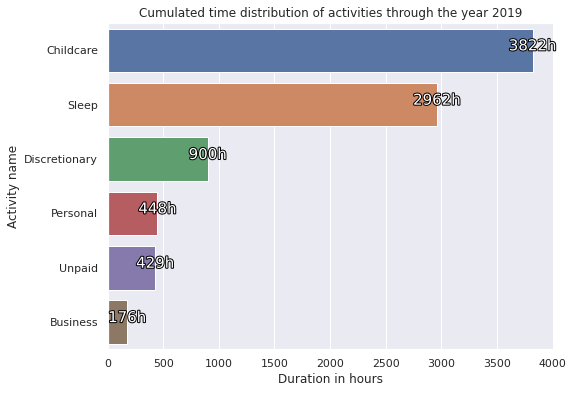

In [65]:
import matplotlib.patheffects as path_effects #this is just to get a nice text

plt.figure(figsize=(8,6))
ax = sns.barplot(data=activities_time[:10], x='Duration', y='category_group')
plt.title('Cumulated time distribution of activities through the year 2019')
ax.set(xlabel='Duration in hours', ylabel='Activity name')

for index, row in activities_time.iterrows():
    text = ax.text(row.Duration, index, str(round(row.Duration))+'h', color='white', ha="center", fontsize=15)

    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])

plt.show()

# Grouping data by minutes, then hours

This bloc of code contains some javascript to handle a dynamic loading bar for the next part.

In [68]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))
out = display(progress(0, 100), display_id=True)

This is the part that takes a long time : please wait for the loading bar completion (tested on Google Colab).

In this section, we duplicate each event for each minute of its duration. Given that there are 4000+ events logged and we create a row for each minute, some events having several hours of duration, we have to wait approx 5mins for computation.

In [70]:
#lets try to duplicate each event for each minute
lifelog_test = lifelog.copy()

#divide the duration by 60 to ge the minutes
lifelog_test['Duration'] = lifelog_test.apply(lambda row: int(row['Duration']/60), axis=1)

new_rows = []
for cpt in range(0, len(lifelog_test)):
  timestamp_start = lifelog_test.loc[cpt]['Timestamp']
  while (timestamp_start < lifelog_test.loc[cpt]['End timestamp']):
    new_rows.append([timestamp_start, lifelog_test.loc[cpt]['Record category']])
    timestamp_start += timedelta(minutes=1)
  out.update(progress(cpt, len(lifelog_test)))

lifelog_by_minutes_df = pd.DataFrame(new_rows, columns=['timestamp', 'category'])
lifelog_by_minutes_df

,timestamp,category
0,2019-01-01 02:00:00,Sleep
1,2019-01-01 02:01:00,Sleep
2,2019-01-01 02:02:00,Sleep
3,2019-01-01 02:03:00,Sleep
4,2019-01-01 02:04:00,Sleep
...,...,...
524189,2019-12-31 07:29:00,Sleep
524190,2019-12-31 07:30:00,Sleep
524191,2019-12-31 07:31:00,Sleep
524192,2019-12-31 07:32:00,Sleep


We collapse all events on month/day/hour so each line contains a tuple of all events that happened in the hour.  
This operation combined with the explosion of each event (one row per minute of event) allows to add events on hours that don't correspond to either a start or end timestamp (intermediate timeslots have the event attributed).

In [128]:
#we group all values by month, day, hour
times = pd.DatetimeIndex(lifelog_by_minutes_df.timestamp)
lifelog_by_hours_df_grouped = lifelog_by_minutes_df.groupby([times.month, times.day, times.hour]).agg(lambda col: list(col))
lifelog_by_hours_df_grouped['category'] = lifelog_by_hours_df_grouped.apply(lambda row: tuple(set(row['category'])), axis=1)
lifelog_by_hours_df_grouped.columns = ['timestamp', 'cat_tuple']
lifelog_by_hours_df_grouped.index.names = ['month', 'day', 'hour']
del lifelog_by_hours_df_grouped['timestamp']
lifelog_by_hours_df_grouped = lifelog_by_hours_df_grouped.reset_index()
lifelog_by_hours_df_grouped

,month,day,hour,cat_tuple
0,1,1,2,"(Sleep,)"
1,1,1,3,"(Sleep,)"
2,1,1,4,"(Sleep,)"
3,1,1,5,"(Sleep,)"
4,1,1,6,"(Sleep,)"
...,...,...,...,...
8736,12,31,3,"(Sleep,)"
8737,12,31,4,"(Sleep,)"
8738,12,31,5,"(Sleep,)"
8739,12,31,6,"(Sleep,)"


# Windowization Algorithm

Next we perform the windowization algorithm on the collapsed dataset.

In [165]:
lifelog_by_hours_df_test = lifelog_by_hours_df_grouped[:100]
# lifelog_by_hours_df_test[(lifelog_by_hours_df_test.month == 1) & (lifelog_by_hours_df_test.day == 1) & (lifelog_by_hours_df_test.hour == 4)]
# lifelog_by_hours_df_test

# as the events are logged hour by hour, we just have to create a list with events from every two rows
maxSpan = 2

def grouped_hours_df_to_event_list(lifelog_by_hours_df_grouped):

  windows = []

  for cpt in range(0, len(lifelog_by_hours_df_grouped), maxSpan):
    event = [list(lifelog_by_hours_df_grouped.loc[cpt]['cat_tuple'])]
    for local_span in range(0, maxSpan-1):
      if (cpt+local_span) in lifelog_by_hours_df_grouped.index.values:
        event.append(list(lifelog_by_hours_df_grouped.loc[cpt+local_span]['cat_tuple']))
        # event = list(set(event))

    windows.append(event)
    
  return windows

#print an extract of the list
event_list = grouped_hours_df_to_event_list(lifelog_by_hours_df_grouped)
event_list[:10]

[[['Sleep'], ['Sleep']],
 [['Sleep'], ['Sleep']],
 [['Sleep'], ['Sleep']],
 [['Sleep'], ['Sleep']],
 [['Childcare'], ['Childcare']],
 [['Childcare'], ['Childcare']],
 [['Childcare'], ['Childcare']],
 [['Unpaid work - Cook', 'Personal - Routines', 'Childcare'],
  ['Unpaid work - Cook', 'Personal - Routines', 'Childcare']],
 [['Unpaid work - Clean the kitchen', 'Personal - Routines', 'Childcare'],
  ['Unpaid work - Clean the kitchen', 'Personal - Routines', 'Childcare']],
 [['Personal - Routines'], ['Personal - Routines']]]

# PrefixSpan Algorithm - IMPORTS

In [154]:
import copy
import itertools
from collections import defaultdict
from operator import itemgetter

In [155]:
"""
This is a simple recursive method that checks if subsequence is a subSequence of mainSequence
"""
def isSubsequence(mainSequence, subSequence):
    subSequenceClone = list(subSequence) # clone the sequence, because we will alter it
    return isSubsequenceRecursive(mainSequence, subSequenceClone) #start recursion

"""
Function for the recursive call of isSubsequence, not intended for external calls
"""
def isSubsequenceRecursive(mainSequence, subSequenceClone, start=0):
    # Check if empty: End of recursion, all eventsets have been found
    if (not subSequenceClone):
        return True
    # retrieves element of the subsequence and removes is from subsequence 
    firstElem = set(subSequenceClone.pop(0))
    # Search for the first eventset...
    for i in range(start, len(mainSequence)):
        if (set(mainSequence[i]).issuperset(firstElem)):
            # and recurse
            return isSubsequenceRecursive(mainSequence, subSequenceClone, i + 1)
    return False

In [156]:
"""
Computes the length of the pattern (subsequence) (sum of the length of the contained eventsets)
"""
def sequenceLength(sequence):
    return sum(len(i) for i in sequence)

In [157]:
"""
Computes the support of a pattern (subsequence) in a dataset
"""
def countSupport (dataset, candidateSequence):
    return sum(1 for seq in dataset if isSubsequence(seq, candidateSequence)) 

In [158]:
"""
Projects a sequence according to a given prefix, as done in PrefixSpan

Args:
    sequence: the sequence the projection is built from
    prefix: the prefix that is searched for in the sequence
    newEvent: if set to True, the first eventset is ignored
Returns:
    If the sequence does not contain the prefix, then None.
    Otherwise, a new sequence starting from the position of the prefix, including the eventset that includes the prefix
"""
def projectSequence(sequence, prefix, newEvent):
    result = None
    for i, eventset in enumerate(sequence):
        if result is None:
            if (not newEvent) or i > 0:
                if (all(x in eventset for x in prefix)):
                    result = [list(eventset)]
        else:
            result.append(copy.copy(eventset))
    return result

In [159]:
"""
Projects a dataset according to a given prefix, as done in PrefixSpan

Args:
    dataset: the dataset the projection is built from
    prefix: the prefix that is searched for in the sequence
    newEvent: if set to True, the first eventset is ignored
Returns:
    A (potentially empty) list of sequences
"""
def projectDatabase(dataset, prefix, newEvent):
    projectedDB = []
    for sequence in dataset:
        seqProjected = projectSequence(sequence, prefix, newEvent)
        if not seqProjected is None:
            projectedDB.append(seqProjected)
    return projectedDB

In [160]:
"""
Generates a list of all items that are contained in a dataset
"""
def generateItems(dataset):
    return sorted(set ([item for sublist1 in dataset for sublist2 in sublist1 for item in sublist2]))

"""
Computes a defaultdict that maps each item in the dataset to its support
"""
def generateItemSupports(dataset, ignoreFirstEvent=False, prefix=[]):
    result = defaultdict(int)
    for sequence in dataset:
        if ignoreFirstEvent:
            sequence = sequence[1:]
        cooccurringItems = set()
        for eventset in sequence:
            if all(x in eventset for x in prefix):
                for item in eventset:
                    if not item in prefix:
                        cooccurringItems.add(item)
        for item in cooccurringItems:
            result [item] += 1
    return sorted(result.items())

In [161]:
"""
The PrefixSpan algorithm. Computes the frequent patterns in a sequence dataset for a given minFrequency

Args:
    dataset: A list of sequences, for which the frequent (sub-)sequences are computed
    minFrequency: The minimum support that makes a pattern (subsequence) frequent
Returns:
    A list of tuples (s, c), where s is a frequent pattern, and c is the count for that pattern
"""
def prefixSpan(dataset, minFrequency):
    result = []
    itemCounts = generateItemSupports(dataset)
    for item, count in itemCounts:
        if count >= minFrequency:
            newPrefix = [item]
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, [item], False), minFrequency, newPrefix))
    return result

def prefixSpanInternal(dataset, minFrequency, prevPrefixes=[]):
    result = []
    # Add a new event to the prefix
    itemCountSubsequentEvents = generateItemSupports(dataset, True)
    for item, count in itemCountSubsequentEvents:
        if count >= minFrequency:
            newPrefix = copy.deepcopy(prevPrefixes)
            newPrefix.append(item)
            result.append((newPrefix, count))
            result.extend(prefixSpanInternal(projectDatabase(dataset, [item], True), minFrequency, newPrefix))
    return result

# PrefixSpan Algorithm - Execution

In [177]:
prefixSpan_result_100 = prefixSpan(event_list, 100)
prefixSpan_result_100 = pd.DataFrame(prefixSpan_result_100, columns=['Sequence', 'Frequency'])
prefixSpan_result_100

,Sequence,Frequency
0,[Business - Earn - Consulting - E1 - General],114
1,"[Business - Earn - Consulting - E1 - General, ...",114
2,[Childcare],2419
3,"[Childcare, Childcare]",2419
4,"[Childcare, Personal - Routines]",322
5,"[Childcare, Sleep]",331
6,"[Childcare, Unpaid work - Clean the kitchen]",139
7,[Discretionary - Family],159
8,"[Discretionary - Family, Discretionary - Family]",159
9,[Discretionary - Productive - Emacs],101


In [178]:
prefixSpan_result_50 = prefixSpan(event_list, 50)
prefixSpan_result_50 = pd.DataFrame(prefixSpan_result_50, columns=['Sequence', 'Frequency'])
prefixSpan_result_50

,Sequence,Frequency
0,[Business - Earn - Consulting - E1 - General],114
1,"[Business - Earn - Consulting - E1 - General, ...",114
2,[Childcare],2419
3,"[Childcare, Childcare]",2419
4,"[Childcare, Discretionary - Family]",50
5,"[Childcare, Personal - Routines]",322
6,"[Childcare, Sleep]",331
7,"[Childcare, Unpaid work - Clean the kitchen]",139
8,"[Childcare, Unpaid work - Cook]",63
9,[Discretionary - Family],159


In [179]:
prefixSpan_result_5 = prefixSpan(event_list, 5)
prefixSpan_result_5 = pd.DataFrame(prefixSpan_result_5, columns=['Sequence', 'Frequency'])
prefixSpan_result_5

,Sequence,Frequency
0,[Business - Build - Paperwork],14
1,"[Business - Build - Paperwork, Business - Buil...",14
2,"[Business - Build - Paperwork, Childcare]",5
3,[Business - Earn - Consulting - E1 - General],114
4,"[Business - Earn - Consulting - E1 - General, ...",114
...,...,...
193,"[Unpaid work - Tidy up, Discretionary - Produc...",5
194,"[Unpaid work - Tidy up, Personal - Routines]",18
195,"[Unpaid work - Tidy up, Sleep]",5
196,"[Unpaid work - Tidy up, Unpaid work - Laundry]",5
